In [ ]:
# read json with tweets and perform analysis....

In [399]:
# import modules
import os
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import operator
import json
from collections import Counter
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import seaborn as sns
import pandas as pd
import gensim
from gensim import corpora
import pyLDAvis.gensim
import IPython.display
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from scipy import stats
from operator import itemgetter
import matplotlib.pyplot as plt

In [400]:
#import sys
#!{sys.executable} -m pip install pyLDAvis

In [401]:
# setup working directory
os.chdir('/Users/a.a.gonzalez.paje/Box Sync/Alberto/rapid_intel/toolkit/fy20/pydata/hacks/02')

In [522]:
# define data file name
term = '#ai'
output_file_name = 'listener_results_' + term + '.json'
print(output_file_name)

listener_results_#ai.json


In [523]:
# load data
input_file = output_file_name
df = pd.read_json(input_file,orient = 'records', lines = True)
print(df.shape)

(6886, 36)


In [524]:
# cleaning 1: define
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-524-7c1eb81453a3>:3: DeprecationWarning: invalid escape sequence \w
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


In [525]:
# cleaning 1: run
df['text_clean'] = np.array([clean_tweet(tweet) for tweet in df['text']])
print (df['text_clean'].head())

0    RT Here is an interesting article on the Machi...
1                       RT AI Dali Lives 1989 CG CG AI
2    RT trans4m Microsoft is cutting dozens of MSN ...
3    RT Here is an interesting article on the Machi...
4                       RT AI Dali Lives 1989 CG CG AI
Name: text_clean, dtype: object


In [526]:
# cleaning 2: define (includes stopwords + customised stop words)
stop_it = stopwords.words('english') + ['rt','RT','via','️','❗','…',"0","1","2","3","4","5","6","7","8","9",'ai','gt']

def clean_tweet_ngrams(tweet,stemming=False):
     '''
     Utility function to clean the text in a tweet by trasnforming to lower case,
     stemming and removing stopwords
     '''
     tweet = tweet.lower()
     tweet = tweet.split()
     if stemming==False:
         tweet = [word for word in tweet if not word in stop_it]
     else:
         ps = PorterStemmer()
         tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
     tweet = ' '.join(tweet)
     return tweet

In [527]:
# cleaning 2: run
df['text_clean_ngrams'] = np.array([ clean_tweet_ngrams(tweet) for tweet in df['text_clean'] ])    
print (df['text_clean_ngrams'].head())

0    interesting article machinelearning prediction...
1                                dali lives 1989 cg cg
2    trans4m microsoft cutting dozens msn news prod...
3    interesting article machinelearning prediction...
4                                dali lives 1989 cg cg
Name: text_clean_ngrams, dtype: object


In [528]:
df.head(1)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,timestamp_ms,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,display_text_range,extended_entities,text_clean,text_clean_ngrams
0,2020-05-30 09:47:41+00:00,1266667590601981957,1266667590601981952,RT @thinksysinc: Here is an interesting articl...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,2020-05-30 09:47:41.802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT Here is an interesting article on the Machi...,interesting article machinelearning prediction...


In [529]:
# bigrams: get
tokens = df['text_clean_ngrams'].apply(nltk.word_tokenize) 
# Flatening nested list
flat_tokens = [term for sublist in tokens for term in sublist]

bgs = nltk.bigrams(flat_tokens)

In [530]:
# bigrams: top 10
fdist = nltk.FreqDist(bgs)
fdist_10 = fdist.most_common(10)
fdist_10

[(('artificial', 'intelligence'), 398),
 (('analytics', 'datascience'), 342),
 (('bigdata', 'analytics'), 341),
 (('machine', 'learning'), 245),
 (('iot', 'iiot'), 195),
 (('datascience', 'machinelearning'), 174),
 (('datascience', 'iot'), 137),
 (('machinelearning', 'iot'), 126),
 (('national', 'portal'), 117),
 (('launched', 'national'), 115)]

In [531]:
# bigrams: source and target
labels = ['bigram', 'Weight']
df_bigrams = pd.DataFrame([tuple_item for tuple_item in fdist.items()], columns =labels)
df_bigrams[['Source_Name','Target_Name']]=pd.DataFrame([tuple_item for tuple_item in df_bigrams.bigram])
#sort in descending order
df_bigrams.sort_values(by='Weight',ascending=False).head(3)

,bigram,Weight,Source_Name,Target_Name
21,"(artificial, intelligence)",398,artificial,intelligence
187,"(analytics, datascience)",342,analytics,datascience
186,"(bigdata, analytics)",341,bigdata,analytics


In [532]:
# bigrams: filter by frequency
df_bigrams_sub=df_bigrams[df_bigrams['Weight']>1] # Change your weighting filter as needed
print (df_bigrams_sub.head(3))

bigram  Weight      Source_Name      Target_Name
0          (interesting, article)       5      interesting          article
1      (article, machinelearning)       2          article  machinelearning
2  (machinelearning, predictions)       2  machinelearning      predictions


In [533]:
# bigrams: nodes table
idx =['bigram','Weight']
multi_indexed_df = df_bigrams_sub.set_index(idx)
multi_indexed_df.head(2)
multi_indexed_df.columns.name = 'word1_2'
stacked_df = multi_indexed_df.stack(dropna=False)
stacked_df.name = 'Label'
stacked_df=stacked_df.reset_index()

In [534]:
# bigrams: nodes table; get number of bigrams to evaluate network size...
print('shape stacked_df:',stacked_df.shape)
Label_unique=stacked_df.Label.unique()
print (Label_unique[0:2])
print ('length unique labels:',len(Label_unique))

shape stacked_df: (17746, 4)
['interesting' 'article']
length unique labels: 4176


In [535]:
# bigrams: nodes table (part 2)
gephi1 = []
i=0
for item in Label_unique: 
    i=i+1
    gephi1.append({'Label': item, 'Id': i})

gephi1=pd.DataFrame(gephi1)

mydict={}
i = 0
for item in Label_unique:    
    i = i+1
    mydict[item] = i

In [536]:
# bigrams: nodes table (part 3) > generate csv file
output_file_name_nodes = 'bigrams_nodes_table_' + term + '.csv'
gephi1[['Id','Label']].to_csv(output_file_name_nodes,index=False)
print (output_file_name_nodes)

bigrams_nodes_table_#ai.csv


In [537]:
# bigrams: relations table
df_bigrams_sub['Source']=np.array([mydict[item] for item in df_bigrams_sub['Source_Name']])
df_bigrams_sub['Target']=np.array([mydict[item] for item in df_bigrams_sub['Target_Name']])
output_file_name_relations = 'bigrams_relations_table_' + term + '.csv'
df_bigrams_sub[['Source','Target','Weight']].to_csv(output_file_name_relations,index=False)
print(output_file_name_relations)

bigrams_relations_table_#ai.csv


In [538]:
df_bigrams_sub

,bigram,Weight,Source_Name,Target_Name,Source,Target
0,"(interesting, article)",5,interesting,article,1,2
1,"(article, machinelearning)",2,article,machinelearning,2,3
2,"(machinelearning, predictions)",2,machinelearning,predictions,3,4
3,"(predictions, 2020)",13,predictions,2020,4,5
4,"(2020, ml)",3,2020,ml,5,6
...,...,...,...,...,...,...
24505,"(face, moneymaker)",2,face,moneymaker,1178,4175
24506,"(moneymaker, diply)",2,moneymaker,diply,4175,4176
24507,"(diply, technology)",2,diply,technology,4176,79
24508,"(technology, facialrecognition)",2,technology,facialrecognition,79,1585


In [539]:
gephi1

,Label,Id
0,interesting,1
1,article,2
2,machinelearning,3
3,predictions,4
4,2020,5
...,...,...
4171,ticking,4172
4172,derwent,4173
4173,characters,4174
4174,moneymaker,4175


In [540]:
#####################################################################

In [541]:
# sentiment
def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [542]:
df['SA'] = np.array([analize_sentiment(tweet) for tweet in df['text_clean']])
pos_tweets = [tweet for index, tweet in enumerate(df['text']) if df['SA'][index] > 0]
print ("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['text'])))
neu_tweets = [tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 0]
print ("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text'])))
neg_tweets = [tweet for index, tweet in enumerate(df['text']) if df['SA'][index] < 0]
print ("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(df['text'])))

Percentage of positive tweets: 34.91141446413012%
Percentage of neutral tweets: 53.39819924484461%
Percentage of negative tweets: 11.690386291025268%


In [543]:
df.head(1)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_tweet,display_text_range,extended_entities,text_clean,text_clean_ngrams,SA
0,2020-05-30 09:47:41+00:00,1266667590601981957,1266667590601981952,RT @thinksysinc: Here is an interesting articl...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT Here is an interesting article on the Machi...,interesting article machinelearning prediction...,1


In [544]:
for col in df.columns:
    print(col)

created_at
id
id_str
text
source
truncated
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
user
geo
coordinates
place
contributors
retweeted_status
is_quote_status
quote_count
reply_count
retweet_count
favorite_count
entities
favorited
retweeted
possibly_sensitive
filter_level
lang
timestamp_ms
quoted_status_id
quoted_status_id_str
quoted_status
quoted_status_permalink
extended_tweet
display_text_range
extended_entities
text_clean
text_clean_ngrams
SA


In [545]:
# export to csv for sanity checks...
#df.to_csv('ai.csv',encoding='utf-8')

In [546]:
# topic modeling: generate dictionary and document term matrix
dictionary = corpora.Dictionary(tokens)
doc_term_matrix = [dictionary.doc2bow(tweet) for tweet in tokens]

In [1]:
# topic modeling: LDA
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix,num_topics = 4,id2word=dictionary,passes=50)
lda_vis = pyLDAvis.gensim.prepare(ldamodel,doct_term_matrix,dictionary)

NameError: name 'gensim' is not defined

In [548]:
# topic modeling: LDA vis
pyLDAvis.enable_notebook(local=False)
pyLDAvis.save_html(lda_vis,'topic_modeling_twitter.html')
pyLDAvis.display(lda_vis)

In [549]:
# Topic modeling: TFIDF
tf_vectorizer = CountVectorizer(min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df['text_clean_ngrams'])
tf_feature_names = tf_vectorizer.get_feature_names()
dtm_tf

<6886x1236 sparse matrix of type '<class 'numpy.int64'>'
	with 45474 stored elements in Compressed Sparse Row format>

In [550]:
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [551]:
def display_topics(model, feature_names, no_top_words): 
    for topic_idx, topic in enumerate(model.components_): 
        print("Topic %d:" % (topic_idx)) 
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [552]:
no_top_words = 10
display_topics(lda_tf, tf_feature_names, no_top_words)

Topic 0:
machinelearning artificialintelligence us learning launched machine meity tech portal bone
Topic 1:
machinelearning bigdata artificial intelligence iot datascience analytics 2020 iiot python
Topic 2:
amp latest harrer world daily thanks emergingtechnologies robotics iot pwc
Topic 3:
iot next data fintech deeplearning deep blockchain covid learning using
Topic 4:
data machine learning datascience machinelearning artificialintelligence bigdata innovation javascript iot


In [553]:
#####################################################################

In [554]:
# network interactions: original code here: https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb
# flatten dictionaries inside dataframe
df_entities = pd.DataFrame(df['entities'].tolist())

In [555]:
df_entities[1:2]

,hashtags,urls,user_mentions,symbols,media
1,"[{'text': 'AI', 'indices': [134, 137]}]",[],"[{'screen_name': 'transhumanistjp', 'name': '日...",[],NaN


In [556]:
df.columns

Index(['created_at', 'id', 'id_str', 'text', 'source', 'truncated',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweeted_status', 'is_quote_status', 'quote_count',
       'reply_count', 'retweet_count', 'favorite_count', 'entities',
       'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang',
       'timestamp_ms', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'quoted_status_permalink', 'extended_tweet',
       'display_text_range', 'extended_entities', 'text_clean',
       'text_clean_ngrams', 'SA'],
      dtype='object')

In [557]:
tweets_df = df # renaming the main df here....
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id","retweeted_id", "retweeted_screen_name","user_mentions_screen_name", "user_mentions_id", "text", "user_id", "screen_name", "followers_count"])

In [558]:
equal_columns = ["created_at", "id", "text"]
tweets_final[equal_columns] = tweets_df[equal_columns]

In [559]:
#Get the basic information about user 
def get_basics(tweets_final):
    tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
    tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
    tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
    return tweets_final

In [560]:
# Get the user mentions 
def get_usermentions(tweets_final):
    # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
    tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return tweets_final

In [561]:
# Get retweets
def get_retweets(tweets_final):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets_final

In [562]:
# Get the information about replies
def get_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
    tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
    tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
    return tweets_final

In [563]:
# Lastly fill the new dataframe with the important information
def fill_df(tweets_final):
    get_basics(tweets_final)
    get_usermentions(tweets_final)
    get_retweets(tweets_final)
    get_in_reply(tweets_final)
    return tweets_final

In [564]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [565]:
tweets_final = fill_df(tweets_final)

In [566]:
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)

In [567]:
tweets_final.head(1)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count
0,2020-05-30 09:47:41+00:00,1266667590601981957,None,None,None,529255051,thinksysinc,thinksysinc,529255051,RT @thinksysinc: Here is an interesting articl...,605434880,2601Manish,2886


In [568]:
graph = nx.Graph()

In [569]:
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name

In [570]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 3516 nodes and 4211 edges present in the Graph


In [571]:
degrees = [val for (node, val) in graph.degree()]

In [572]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 164
The minimum degree of the Graph is 1


In [573]:
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The average degree of the nodes in the Graph is 2.4
The most frequent degree of the nodes found in the Graph is 1


In [574]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [575]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 596 connected components in the Graph


In [576]:
graph_centrality = nx.degree_centrality(graph)
graph_closeness = nx.closeness_centrality(graph)
graph_betweenness = nx.betweenness_centrality(graph, normalized=True, endpoints=False)
max_de = max(graph_centrality.items(), key=itemgetter(1))
max_clo = max(graph_closeness.items(), key=itemgetter(1))
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [577]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id 723930351358222337 has a degree centrality of 0.05 which is the maximum of the Graph
the node with id 723930351358222337 has a closeness centrality of 0.22 which is the maximum of the Graph
the node with id 723930351358222337 has a betweenness centrality of 0.14 which is the maximum of the Graph


In [578]:
node_and_degree = graph.degree()
colors_central_nodes = ['orange']
central_nodes = ['723930351358222337']

In [579]:
pos = nx.spring_layout(graph, k=0.05)

In [580]:
graph.number_of_edges()

4211

In [581]:
number_nodes = graph.number_of_nodes()
number_nodes

3516

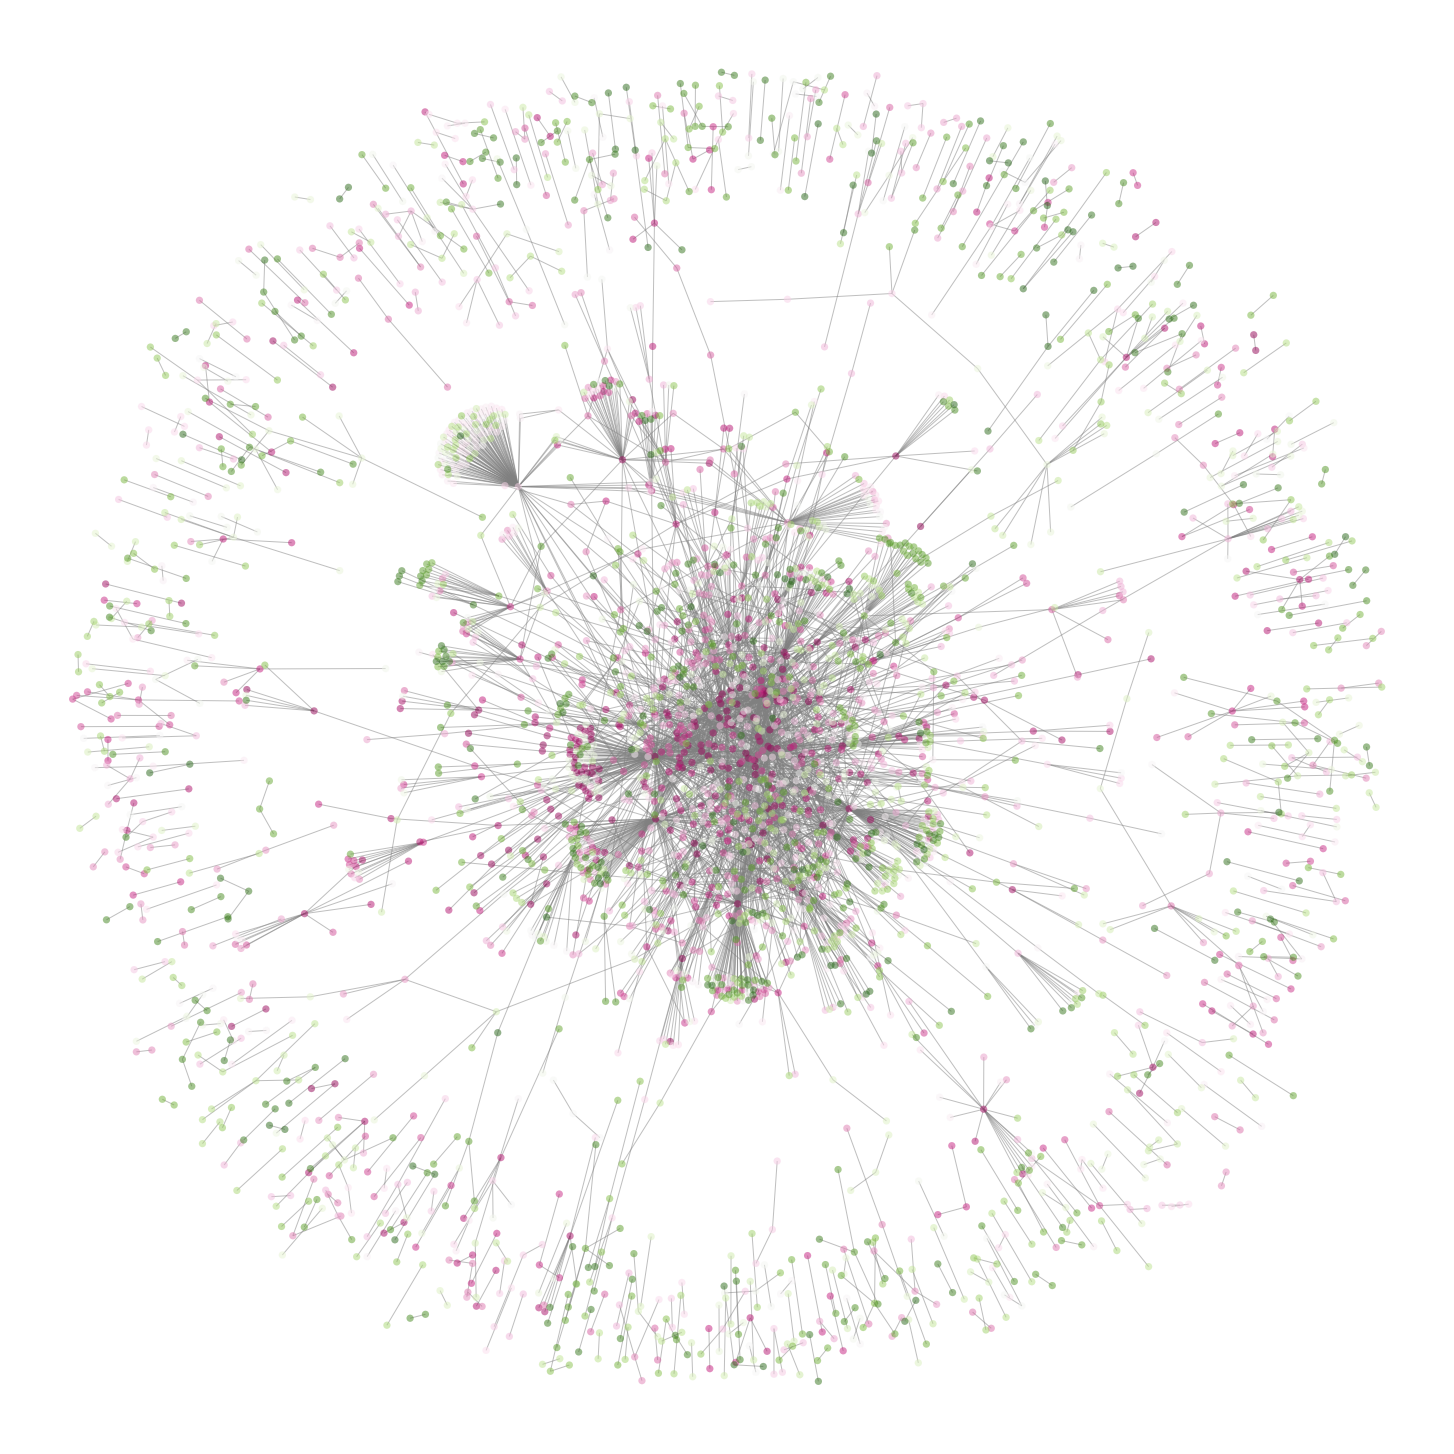

In [582]:
plt.figure(figsize = (20,20))
nx.draw(graph, pos=pos, node_color=range(number_nodes), cmap=plt.cm.PiYG, edge_color="grey", linewidths=0.1, node_size=50, alpha=0.5, with_labels=False)
plt.savefig('graphfinal.png')
plt.show()